In [1]:
import pandas as pd
import numpy as np
import datetime
import math
Billing = pd.read_csv("FullData/Billing.csv")
DiseaseCase = pd.read_csv("FullData/DiseaseCase.csv")

In [2]:
print("Billing information -----")
print(Billing.isnull().sum())
print(len(Billing['Patient_ID'].unique()))
print(len(Billing.index))
print("\nDisease information -----")
print(len(DiseaseCase.index), len(DiseaseCase['Patient_ID'].unique()))
print(DiseaseCase['Disease'].value_counts())

Billing information -----
Patient_ID               0
ServiceDate           6641
DiagnosisText_calc       0
DiagnosisCode_calc       0
dtype: int64
93849
3781023

Disease information -----
270459 149376
Diabetes Mellitus         146762
Diabetes Mellitus (ml)    123697
Name: Disease, dtype: int64


In [3]:
Billing = Billing.dropna(subset=['ServiceDate'])
print(len(Billing.index))

3774382


In [4]:
# Prepare disease case data
DiseaseCase['Disease'] = DiseaseCase['Disease'].replace("Diabetes Mellitus (ml)","Diabetes Mellitus") # Make all DM2 diagnosis' the same
DiseaseCase['DateOfOnset'] = pd.to_datetime(DiseaseCase.DateOfOnset,format='%Y-%m-%d')
DiseaseCase = DiseaseCase.sort_values(by='DateOfOnset', ascending = True)
DiseaseCase = DiseaseCase.drop_duplicates(subset = ['Patient_ID'])
print(len(DiseaseCase['Patient_ID'].unique()), len(DiseaseCase.index))

149376 149376


In [5]:
DM2DF = Billing[pd.to_numeric(Billing.DiagnosisCode_calc,errors='coerce').notnull()] # convert diagnosis codes to floats
DM2DF['DiagnosisCode_calc'] = pd.to_numeric(DM2DF['DiagnosisCode_calc']) # convert diagnosis codes to floats
DM2DF['ServiceDate'] = pd.to_datetime(DM2DF.ServiceDate,format='%Y-%m-%d')
DM2DF = pd.merge(DM2DF,DiseaseCase[['Patient_ID','DateOfOnset']], on='Patient_ID')

<ipython-input-5-126f0533c5dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DM2DF['DiagnosisCode_calc'] = pd.to_numeric(DM2DF['DiagnosisCode_calc']) # convert diagnosis codes to floats
<ipython-input-5-126f0533c5dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DM2DF['ServiceDate'] = pd.to_datetime(DM2DF.ServiceDate,format='%Y-%m-%d')


In [6]:
len(DM2DF.index)

3508064

### Get DM2 patients with a complication

In [7]:
## The 10 Complications
complications = {
    'AP' : [float(item/100) for item in range(41300,41400)], # http://www.icd9data.com/2013/Volume1/390-459/410-414/413/default.htm
    'AS' : [float(item/100) for item in range(44000,44100)], # http://www.icd9data.com/2012/Volume1/390-459/440-449/440/default.htm
    'ICHD' : [float(item/100) for item in range(41400,41500)], # http://www.icd9data.com/2015/Volume1/390-459/410-414/414/default.htm
    'DD' : [311], # http://www.icd9data.com/2012/Volume1/290-319/300-316/311/default.htm
    'DNP' : [float(item/100) for item in range(58500,58600)] + [581.81], # include 250.4? http://www.icd9data.com/2012/Volume1/580-629/580-589/585/default.htm
    'DNU' : [float(item/100) for item in range(35700,35800)], # include 250.6? 357.2 is the exact code http://www.icd9data.com/2012/Volume1/320-389/350-359/357/default.htm 
    'DR' : [float(item/100) for item in range(36200,36210)], # http://www.icd9data.com/2015/Volume1/320-389/360-379/362/default.htm
    'HL' : [389.9], #http://www.icd9data.com/2012/Volume1/320-389/380-389/389/default.htm
    'MI' : [float(item/100) for item in range(41000,41100)], #http://www.icd9data.com/2014/Volume1/390-459/410-414/410/default.htm
    'PVD' : [float(item/100) for item in range(43300,43400)] #http://www.icd9data.com/2013/Volume1/390-459/440-449/443/default.htm
}

In [8]:
for k,v in complications.items() :
    compRows = DM2DF.loc[DM2DF['DiagnosisCode_calc'].isin(v)]
    uniqPatients = compRows['Patient_ID'].unique()
    print(k, "has", len(uniqPatients), "unique patients")

AP has 3304 unique patients
AS has 559 unique patients
ICHD has 5827 unique patients
DD has 13569 unique patients
DNP has 3603 unique patients
DNU has 1383 unique patients
DR has 365 unique patients
HL has 307 unique patients
MI has 1032 unique patients
PVD has 224 unique patients


In [9]:
def DiseasePeriod(compDF) :
    compIDs = compDF.sort_values(by='ServiceDate', ascending = True)
    compIDs = compIDs[compIDs['ServiceDate'] > compIDs['DateOfOnset']]
    compIDs = compIDs.drop_duplicates(subset = ['Patient_ID'])
    compIDs = compIDs[['Patient_ID', 'ServiceDate']]
    compIDs.columns = ['Patient_ID', 'CompOnset']
    return compIDs

In [10]:
from random import sample
def negativeSamples(posDF) :
    # Negative set
    NegBillingSet = DM2DF.loc[~DM2DF['Patient_ID'].isin(posDF['Patient_ID'])]
    
    # Remove patients with only 1 visit and more than 50 visits
    NegBillingSet = NegBillingSet[NegBillingSet.groupby('Patient_ID').Patient_ID.transform('count') > 1]
    NegBillingSet = NegBillingSet[NegBillingSet.groupby('Patient_ID').Patient_ID.transform('count') < 51]

    
    # Randomly sample negative class for 1:1 positive negative ratio
    NegIDs = NegBillingSet['Patient_ID'].unique().tolist()
    NegSample = sample(NegIDs,len(posDF['Patient_ID'].unique()))
    NegBillingSample = NegBillingSet.loc[NegBillingSet['Patient_ID'].isin(NegSample)]
    
    return NegBillingSample

In [11]:
temp = []

In [12]:
def subsetVisits(compCodes) :
    
    # Subset Billing for complication codes
    compDF = DM2DF.loc[DM2DF['DiagnosisCode_calc'].isin(compCodes)]
    
    # find relevant patientID's and compOnsets
    diseasePeriod = DiseasePeriod(compDF)
    
    # Subset Billing by patient's with complication
    bSs = DM2DF.loc[DM2DF['Patient_ID'].isin(diseasePeriod['Patient_ID'])]
    
    # Merge
    bSs = pd.merge(bSs, diseasePeriod, on='Patient_ID')
    
    # Get rid of visits outside of disease period
    relVisits = bSs[(bSs['ServiceDate'] < bSs['CompOnset']) & (bSs['ServiceDate'] >= bSs['DateOfOnset'])]
    
    #Remove patients with less than 4 visits and more than 50
    relVisits = relVisits[relVisits.groupby('Patient_ID').Patient_ID.transform('count') > 4]
    relVisits = relVisits[relVisits.groupby('Patient_ID').Patient_ID.transform('count') < 51]
    temp.append(len(relVisits['Patient_ID'].unique()))
    
    #Merge with negative sample
    negSample = negativeSamples(relVisits)
    temp.append(len(negSample['Patient_ID'].unique()))
    relVisits = relVisits.append(negSample, ignore_index=True)
    
    return relVisits

In [13]:
# Gather all patient visits per patient between diagnosis' in a dictionary
def patientHistories(dataframe) :
    AllVisits = {}
    for index, row in dataframe.iterrows() :
        temp = (str(row['Patient_ID']),str(row['ServiceDate']))
        diag = row['DiagnosisCode_calc']
        if temp not in AllVisits.keys():
            AllVisits[temp] = []
        AllVisits[temp] = AllVisits[temp] + [diag]
        
    PVDF = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in AllVisits.items() ]))
    PVDF = PVDF.transpose()
    PVDF = PVDF.dropna(axis=0,how='all') # Remove NA
    return PVDF

In [14]:
subVisits = {}
seqVisits = {}
for k, v in complications.items() :
    compVisits = subsetVisits(v)
    subVisits[k] = compVisits
    seqVisits[k] = patientHistories(compVisits)

In [15]:
temp

[1563,
 1563,
 274,
 274,
 2716,
 2716,
 6359,
 6359,
 1967,
 1967,
 770,
 770,
 180,
 180,
 139,
 139,
 446,
 446,
 114,
 114]

In [16]:
MIpatients = subVisits['DNU'].dropna(subset=['CompOnset']) # CHange from MI to DNU
MIpatients = MIpatients['Patient_ID'].unique().tolist()
MIpatients

[1000100081489,
 1000100038199,
 1000100086550,
 1000100083678,
 1000100164719,
 1000100018645,
 1000100084083,
 1000100166667,
 1000100083081,
 1000100082107,
 1000100081780,
 1000100166196,
 1000100028510,
 1000100081775,
 1000100027350,
 1000100030119,
 1000100004753,
 1000100317029,
 1000100080550,
 1000100084428,
 1000100009372,
 1000100035993,
 1000100084191,
 1000100032231,
 1000100047117,
 1000100164182,
 1000100086524,
 1000100084082,
 1000100164532,
 1000100086900,
 1000100316916,
 1000100164236,
 1000100167105,
 1000100082827,
 1000100415918,
 1000100086646,
 1000100164426,
 1000100166552,
 1000100044862,
 1000100165141,
 1000100317972,
 1000100094519,
 1000100091333,
 1000100088844,
 1000100094758,
 1000100232993,
 1000100091934,
 1000100096059,
 1000100013912,
 1000100092694,
 1000100095452,
 1000100091455,
 1000100091896,
 1000100335971,
 1000100090523,
 1000100090880,
 1000100096760,
 1000100096297,
 1000100020920,
 1000100272425,
 1000100319719,
 1000100092799,
 1000100

In [18]:
seqVisits['MI'].index.get_level_values(0).value_counts()

2000200031696     50
1000100029320     48
1000100485838     47
10001000111970    47
1000100301554     46
                  ..
5050180012600      1
2000200062323      1
4000000393628      1
5050180078593      1
10001000142497     1
Length: 1040, dtype: int64

### Feature vector creation

In [17]:
test = seqVisits['DNU']

In [18]:
len(test.index)

24510

In [19]:
# Check # of unique ICD9 codes
len(DM2DF['DiagnosisCode_calc'].value_counts().index)

5432

In [20]:
# Remove ICD9 codes that only appear once
ICD9s = DM2DF['DiagnosisCode_calc'].value_counts()
ICD9s = ICD9s[DM2DF['DiagnosisCode_calc'].value_counts() > 5]
ICD9s.index

Float64Index([ 250.0,  401.0,  780.0,  311.0,  300.0,  799.0,  401.9,  715.0,
               428.0,  781.0,
              ...
               999.5, 376.89,  879.4,  272.6,  778.0,  676.6,  478.4,  524.3,
               910.8,  301.4],
             dtype='float64', length=3397)

In [21]:
# Create new array for SVD input where columns = all possible ICD9 codes, rows are each visit, filled in with 0s
RowFeatures = pd.DataFrame(data = 0,
                           index = test.index,
                           columns=ICD9s.index)
RowFeatures.head()

250.00  401.00  780.00  311.00  300.00  \
1000100081489 2007-08-29 00:00:00       0       0       0       0       0   
              2007-07-05 00:00:00       0       0       0       0       0   
              2007-07-17 00:00:00       0       0       0       0       0   
              2007-11-06 00:00:00       0       0       0       0       0   
              2008-01-18 00:00:00       0       0       0       0       0   

                                   799.00  401.90  715.00  428.00  781.00  \
1000100081489 2007-08-29 00:00:00       0       0       0       0       0   
              2007-07-05 00:00:00       0       0       0       0       0   
              2007-07-17 00:00:00       0       0       0       0       0   
              2007-11-06 00:00:00       0       0       0       0       0   
              2008-01-18 00:00:00       0       0       0       0       0   

                                   ...  999.50  376.89  879.40  272.60  \
1000100081489 2007-08-29 00:00:00  ...       0       0       0       0   
              2007-07-05 00:00:00  ...       0       0       0       0   
              2007-07-17 00:00:00  ...       0       0       0       0   
              2007-11-06 00:00:00  ...       0       0       0       0   
              2008-01-18 00:00:00  ...       0       0       0       0   

                                   778.00  676.60  478.40  524.30  910.80  \
1000100081489 2007-08-29 00:00:00       0       0       0       0       0   
              2007-07-05 00:00:00       0       0       0       0       0   
              2007-07-17 00:00:00       0       0       0       0       0   
              2007-11-06 00:00:00       0       0       0       0       0   
              2008-01-18 00:00:00       0       0       0       0       0   

                                   301.40  
1000100081489 2007-08-29 00:00:00       0  
              2007-07-05 00:00:00       0  
              2007-07-17 00:00:00       0  
              2007-11-06 00:00:00       0  
              2008-01-18 00:00:00       0  

[5 rows x 3397 columns]

In [22]:
# if diag occured in a visit, col[diagnosisCode] = 1
for index, row in RowFeatures.iterrows() :
    for diag in test.loc[index].dropna() :
        row[diag] = 1
    

In [23]:
# Take a look at final matrix
RowFeatures

250.00  401.00  780.00  311.00  300.00  \
1000100081489 2007-08-29 00:00:00       0       0       0       0       0   
              2007-07-05 00:00:00       0       0       0       0       0   
              2007-07-17 00:00:00       0       0       0       0       0   
              2007-11-06 00:00:00       0       0       0       0       0   
              2008-01-18 00:00:00       0       0       0       0       0   
...                                   ...     ...     ...     ...     ...   
4000000669567 2019-01-03 00:00:00       0       1       0       0       0   
              2019-03-11 00:00:00       1       0       0       0       0   
              2019-06-14 00:00:00       0       1       0       0       0   
              2019-08-08 00:00:00       0       1       0       0       0   
              2019-09-09 00:00:00       0       1       0       0       0   

                                   799.00  401.90  715.00  428.00  781.00  \
1000100081489 2007-08-29 00:00:00       0       0       0       0       0   
              2007-07-05 00:00:00       0       0       0       0       0   
              2007-07-17 00:00:00       0       0       0       0       0   
              2007-11-06 00:00:00       0       0       0       0       0   
              2008-01-18 00:00:00       0       0       0       0       0   
...                                   ...     ...     ...     ...     ...   
4000000669567 2019-01-03 00:00:00       0       0       0       0       0   
              2019-03-11 00:00:00       0       0       0       0       0   
              2019-06-14 00:00:00       0       0       0       0       0   
              2019-08-08 00:00:00       0       0       0       0       0   
              2019-09-09 00:00:00       0       0       0       0       0   

                                   ...  999.50  376.89  879.40  272.60  \
1000100081489 2007-08-29 00:00:00  ...       0       0       0       0   
              2007-07-05 00:00:00  ...       0       0       0       0   
              2007-07-17 00:00:00  ...       0       0       0       0   
              2007-11-06 00:00:00  ...       0       0       0       0   
              2008-01-18 00:00:00  ...       0       0       0       0   
...                                ...     ...     ...     ...     ...   
4000000669567 2019-01-03 00:00:00  ...       0       0       0       0   
              2019-03-11 00:00:00  ...       0       0       0       0   
              2019-06-14 00:00:00  ...       0       0       0       0   
              2019-08-08 00:00:00  ...       0       0       0       0   
              2019-09-09 00:00:00  ...       0       0       0       0   

                                   778.00  676.60  478.40  524.30  910.80  \
1000100081489 2007-08-29 00:00:00       0       0       0       0       0   
              2007-07-05 00:00:00       0       0       0       0       0   
              2007-07-17 00:00:00       0       0       0       0       0   
              2007-11-06 00:00:00       0       0       0       0       0   
              2008-01-18 00:00:00       0       0       0       0       0   
...                                   ...     ...     ...     ...     ...   
4000000669567 2019-01-03 00:00:00       0       0       0       0       0   
              2019-03-11 00:00:00       0       0       0       0       0   
              2019-06-14 00:00:00       0       0       0       0       0   
              2019-08-08 00:00:00       0       0       0       0       0   
              2019-09-09 00:00:00       0       0       0       0       0   

                                   301.40  
1000100081489 2007-08-29 00:00:00       0  
              2007-07-05 00:00:00       0  
              2007-07-17 00:00:00       0  
              2007-11-06 00:00:00       0  
              2008-01-18 00:00:00       0  
...                                   ...  
4000000669567 2019-01-03 00:00:00       0  
              2019-

### SVD 

In [24]:
# SVD matrices
U, s, V = np.linalg.svd(RowFeatures)
print(U.shape, V.shape, s.shape)

(24510, 24510) (3397, 3397) (3397,)


In [25]:
S = np.zeros((RowFeatures.shape[0], RowFeatures.shape[1]))
S[:RowFeatures.shape[1], :RowFeatures.shape[1]] = np.diag(s)
n_component = 50
S = S[:, :n_component]

In [26]:
reducedMat = U.dot(S)

In [27]:
reducedMat.shape

(24510, 50)

In [28]:
reducedDF = pd.DataFrame(data=reducedMat, index=RowFeatures.index)
reducedDF

0         1         2         3   \
1000100081489 2007-08-29 00:00:00 -0.005151  0.006180 -0.000988  0.000103   
              2007-07-05 00:00:00 -0.001958 -0.000507  0.001672 -0.002324   
              2007-07-17 00:00:00 -0.001472 -0.000376  0.001728 -0.002339   
              2007-11-06 00:00:00 -0.000246 -0.000049  0.000038 -0.000294   
              2008-01-18 00:00:00 -0.000386  0.001019  0.000032 -0.000303   
...                                     ...       ...       ...       ...   
4000000669567 2019-01-03 00:00:00 -0.061630  0.997258 -0.000347  0.006078   
              2019-03-11 00:00:00 -0.997678 -0.062483 -0.009611  0.003556   
              2019-06-14 00:00:00 -0.061630  0.997258 -0.000347  0.006078   
              2019-08-08 00:00:00 -0.061630  0.997258 -0.000347  0.006078   
              2019-09-09 00:00:00 -0.061630  0.997258 -0.000347  0.006078   

                                         4         5         6         7   \
1000100081489 2007-08-29 00:00:00  0.003366  0.001693 -0.036576  0.986799   
              2007-07-05 00:00:00  0.005628  0.001483  0.000253 -0.000226   
              2007-07-17 00:00:00  0.005669  0.001528  0.000278 -0.000185   
              2007-11-06 00:00:00  0.003959  0.000991  0.000158 -0.000025   
              2008-01-18 00:00:00  0.003983  0.000971 -0.000010  0.000740   
...                                     ...       ...       ...       ...   
4000000669567 2019-01-03 00:00:00 -0.013102  0.001882  0.004281 -0.010302   
              2019-03-11 00:00:00 -0.009904  0.002361  0.003411 -0.007006   
              2019-06-14 00:00:00 -0.013102  0.001882  0.004281 -0.010302   
              2019-08-08 00:00:00 -0.013102  0.001882  0.004281 -0.010302   
              2019-09-09 00:00:00 -0.013102  0.001882  0.004281 -0.010302   

                                         8         9   ...        40  \
1000100081489 2007-08-29 00:00:00  0.003979  0.004271  ... -0.000047   
              2007-07-05 00:00:00 -0.000183 -0.000061  ...  0.000088   
              2007-07-17 00:00:00 -0.000115 -0.000038  ...  0.000090   
              2007-11-06 00:00:00  0.000019  0.000002  ...  0.000042   
              2008-01-18 00:00:00 -0.000096 -0.000114  ...  0.000044   
...                                     ...       ...  ...       ...   
4000000669567 2019-01-03 00:00:00  0.002482  0.001019  ... -0.000043   
              2019-03-11 00:00:00  0.002662 -0.000674  ...  0.000259   
              2019-06-14 00:00:00  0.002482  0.001019  ... -0.000043   
              2019-08-08 00:00:00  0.002482  0.001019  ... -0.000043   
              2019-09-09 00:00:00  0.002482  0.001019  ... -0.000043   

                                         41        42        43        44  \
1000100081489 2007-08-29 00:00:00 -0.006514 -0.000833 -0.010098  0.000221   
              2007-07-05 00:00:00  0.009343  0.002399 -0.001780 -0.000432   
              2007-07-17 00:00:00  0.010046  0.002474 -0.001518 -0.000417   
              2007-11-06 00:00:00  0.010042  0.002402 -0.000485 -0.000013   
              2008-01-18 00:00:00  0.009790  0.002411 -0.000475 -0.000087   
...                                     ...       ...       ...       ...   
4000000669567 2019-01-03 00:00:00 -0.005789  0.000606  0.000282  0.001640   
              2019-03-11 00:00:00 -0.001675 -0.000081 -0.000841  0.000614   
              2019-06-14 00:00:00 -0.005789  0.000606  0.000282  0.001640   
              2019-08-08 00:00:00 -0.005789  0.000606  0.000282  0.001640   
              2019-09-09 00:00:00 -0.005789  0.000606  0.000282  0.001640   

                                         45        46        47        48  \
1000100081489 2007-08-29 00:00:00 -0.000336  0.002095 -0.005558 -0.003595   
              2007-07-05 00:00:00 -0.000334 -0.045998  0.004752 -0.002431   
              2007-07-17 00:00:00 -0.000312 -0.046114  0.006015 -0.002786   
              2007-11-06 00:00:00 -0.000902 -0.044874  0.006448 -0.003746   
              20

In [29]:
reducedDF.index.get_level_values(0).value_counts()

1000100410326     50
1000100413176     49
1000100297779     49
1000100160340     48
1000100042774     48
                  ..
11113000022415     1
1000100463077      1
6000600021052      1
5050080028271      1
4000000341709      1
Length: 1540, dtype: int64

In [32]:
# Create dictionary with patients as keys and columns as SVD values
VisitHistorySVD = {}
for index, row in reducedDF.iterrows() :
    temp = int(index[0])
    featureVector = list(row)
    if temp not in VisitHistorySVD.keys():
        if temp in MIpatients :
            VisitHistorySVD[temp] = [1]
        else :
            VisitHistorySVD[temp] = [0]
    VisitHistorySVD[temp] = VisitHistorySVD[temp] + featureVector

In [34]:
print(VisitHistorySVD[1000100410326][0:2],len(VisitHistorySVD[1000100410326]))

[0, -0.9976781911684622] 2501


In [35]:
for k,v in VisitHistorySVD.items() :
    fillLen = 2501 - len(v)
    VisitHistorySVD[k] = v + [0]*fillLen

In [36]:
len(VisitHistorySVD[1000100410326])

2501

In [37]:
X, y = [], []
for k,v in VisitHistorySVD.items() :
    y.append(v[0])
    X.append(v[1:])

In [38]:
print(y.count(1),y.count(0))

770 770


### Machine learning models

In [39]:
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D, GRU, Bidirectional, Input, TimeDistributed, Reshape

In [40]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train), 'training')
print(len(X_test), 'testing')

1232 training
308 testing


In [41]:
# Bidirectional GRU

# Random search drop out rate and number of units/neurons
X_train = np.array(X_train)
X_test = np.array(X_test)
input_shape = (X_train.shape[1], 1) #2500,1

units = 128


model = Sequential()
model.add(Reshape((50, 50), input_shape=(2500,)))
# 1 sees the past 
# 2 sees the past and the future


dropout = 0.2 # for regularization
print('Number of hidden units: ', units, 'Dropout: ', dropout)
model.add(Bidirectional(GRU(units, input_shape=input_shape))) # 64, $128$, 256, 512
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print('Training...')
history = model.fit(
    np.array(X_train),
    np.array(y_train),
    batch_size = 128, 
    epochs = 20,
    validation_split = 0.1
)

Number of hidden units:  128 Dropout:  0.2
Training...
Epoch 1/20
9/9 [==============================] - 3s 207ms/step - loss: 0.6919 - accuracy: 0.5228 - val_loss: 0.6909 - val_accuracy: 0.5081
Epoch 2/20
9/9 [==============================] - 1s 142ms/step - loss: 0.6839 - accuracy: 0.5580 - val_loss: 0.6863 - val_accuracy: 0.5726
Epoch 3/20
9/9 [==============================] - 1s 140ms/step - loss: 0.6790 - accuracy: 0.6034 - val_loss: 0.6811 - val_accuracy: 0.5484
Epoch 4/20
9/9 [==============================] - 1s 141ms/step - loss: 0.6595 - accuracy: 0.6439 - val_loss: 0.6734 - val_accuracy: 0.5726
Epoch 5/20
9/9 [==============================] - 1s 141ms/step - loss: 0.6378 - accuracy: 0.6362 - val_loss: 0.6563 - val_accuracy: 0.5887
Epoch 6/20
9/9 [==============================] - 1s 143ms/step - loss: 0.6143 - accuracy: 0.6579 - val_loss: 0.6416 - val_accuracy: 0.6774
Epoch 7/20
9/9 [==============================] - 1s 140ms/step - loss: 0.5882 - accuracy: 0.6953 - val_l

In [43]:
print(model.evaluate(X_test, np.array(y_test)), "\n\n")

10/10 [==============================] - 0s 23ms/step - loss: 0.6407 - accuracy: 0.6916
[0.6407499313354492, 0.6915584206581116] 




In [44]:
model.predict(X_test[0].reshape(1,2500))

array([[0.5714041]], dtype=float32)

In [45]:
y_test[0]

1

In [46]:
model.predict(X_test[1].reshape(1,2500))

array([[3.0544472e-06]], dtype=float32)

In [47]:
y_test[1]

0

In [48]:
from matplotlib import pyplot as plt

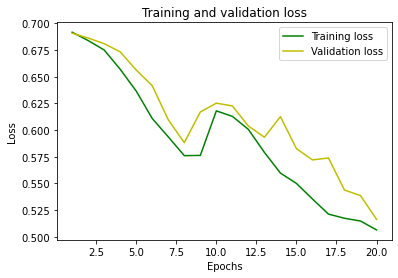

In [49]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

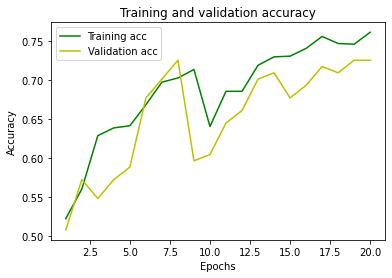

In [50]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1) #?
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [51]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets 
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time

h = .02  # step size in the mesh

names = ["Random Forest", "MLP"]

classifiers = [
    RandomForestClassifier(max_depth=10, n_estimators=100),
    MLPClassifier()
]

print("{0:20}{1:40}\n-----------------------------------------------------".\
      format("Classifier", "Accuracy"))

# iterate over classifiers
for name, clf in zip(names, classifiers):
    
    start_time = time()
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    end_time = time()
    print("{0:20}{1:40}{2:40}".format(name, str(score), (end_time - start_time)))

Classifier          Accuracy                                
-----------------------------------------------------
Random Forest       0.6461038961038961                                            0.6107909679412842
MLP                 0.6071428571428571                                             9.712540864944458


/Users/davidhuang/miniforge3/envs/tfARM/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
